# Repository mining
## Get LOC of VLC

In [228]:
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta
from git import Repo
import pickle 

# Repository URL
repo_url = "https://code.videolan.org/videolan/vlc.git"

# Clone or fetch the repository
repo_path = "vlc"  # Path where the repository will be cloned or fetched
if not os.path.exists(repo_path):
    print("Cloning repository..")
    repo = Repo.clone_from(repo_url, repo_path)
else:
    repo = Repo(repo_path)
    repo.remote().fetch()
    repo.git.checkout("master", force=True)

last_commit = repo.head.commit

# Create the stats dictionary
all_stats = {}
ui_stats = {}

def traverse_commits(update_dict=None):
    if update_dict is None:
        raise ValueError("update_dict must be specified")
    
    # Loop through the commits and collect relevant data for the first commit of each month
    for commit in repo.iter_commits(reverse=True):
        date = datetime.fromtimestamp(commit.committed_date)
        year_month = date.strftime("%Y:%m")

        if update_dict == "ui_stats" and date < datetime(2018, 1, 1):
            continue

        if year_month not in globals()[update_dict] or commit == last_commit: # Check if current commit is the first commit of the year/month seen
            print("Counting LOC at " + year_month + "...")

            repo.git.checkout(commit)

            key = year_month
            globals()[update_dict][key] = {}

            # Run cloc to gather the stats for each language (first line is the header, and the rest represent each language)
            cloc_output = os.popen("cloc " + os.path.join(repo_path, "modules/gui/macosx ") + os.path.join(repo_path, "modules/gui/qt") + " --csv --quiet").read() \
                if update_dict == "ui_stats" else os.popen("cloc " + repo_path + " --csv --quiet --exclude-lang='PO File','SVG','diff'").read()
            lines = cloc_output.splitlines()

            # Extract the stats from the corresponding line in cloc output
            for line in lines[2:]:
                data = line.split(",")
                language = data[1]

                # Extract the stats using the known indices (files,language,blank,comment,code) and store in stats dictionary
                globals()[update_dict][key][language] = {
                    'files': int(data[0]),
                    'blank': int(data[2]),
                    'comment': int(data[3]),
                    'code': int(data[4])
                }

    # Rename Qt to QtWidgets UI
    for _ , value in globals()[update_dict].items():
        if "Qt" in value.keys():
            value["QtWidgets UI"] = value.pop("Qt")

    # Rename WiX source to WiX Toolset
    for _ , value in globals()[update_dict].items():
        if "WiX source" in value.keys():
            value["WiX Toolset"] = value.pop("WiX source")

    # Find the ratio of comment to code for each language
    for _, value in globals()[update_dict].items():
        for language in value.keys():
            value[language]['ratio'] = value[language]['comment'] / value[language]['code'] if value[language]['code'] != 0 else 0

print("Traversing commits monthly and analysing LOC of the entire source code from 1999...")
traverse_commits(update_dict="all_stats")
print("Traversing commits monthly and analysing LOC of only UI components (modules/gui/qt) from 2018...")
traverse_commits(update_dict="ui_stats")

# Save the dictionaries
with open('vlc_all_stats.pkl', 'wb') as f:
    pickle.dump(all_stats, f)

with open('vlc_ui_stats.pkl', 'wb') as f:
    pickle.dump(ui_stats, f)

Cloning repository..
Traversing commits monthly and analysing LOC of the entire source code from 1999...
Counting LOC at 1999:08...
Counting LOC at 1999:09...
Counting LOC at 1999:10...
Counting LOC at 1999:11...
Counting LOC at 1999:12...
Counting LOC at 2000:01...
Counting LOC at 2000:02...
Counting LOC at 2000:03...
Counting LOC at 2000:04...
Counting LOC at 2000:05...
Counting LOC at 2000:06...
Counting LOC at 2000:07...
Counting LOC at 2000:08...
Counting LOC at 2000:10...
Counting LOC at 2000:11...
Counting LOC at 2000:12...
Counting LOC at 2001:01...
Counting LOC at 2001:02...
Counting LOC at 2001:03...
Counting LOC at 2001:04...
Counting LOC at 2001:05...
Counting LOC at 2001:06...
Counting LOC at 2001:07...
Counting LOC at 2001:08...
Counting LOC at 2001:09...
Counting LOC at 2001:10...
Counting LOC at 2001:11...
Counting LOC at 2001:12...
Counting LOC at 2002:01...
Counting LOC at 2002:02...
Counting LOC at 2002:03...
Counting LOC at 2002:04...
Counting LOC at 2002:05...
Coun

In [1]:
import pickle 

# Alternatively, load the dictionaries from the pickle files

all_stats = {}
ui_stats = {}

with open('vlc_all_stats.pkl', 'rb') as f:
    all_stats = pickle.load(f)

with open('vlc_ui_stats.pkl', 'rb') as f:
    ui_stats = pickle.load(f)

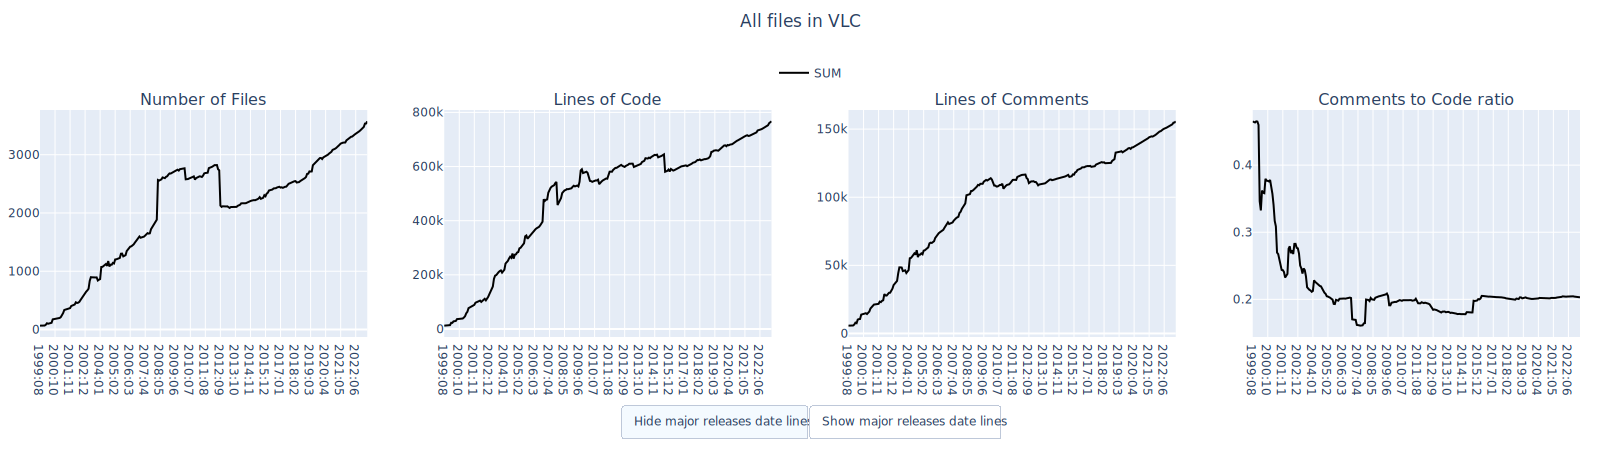

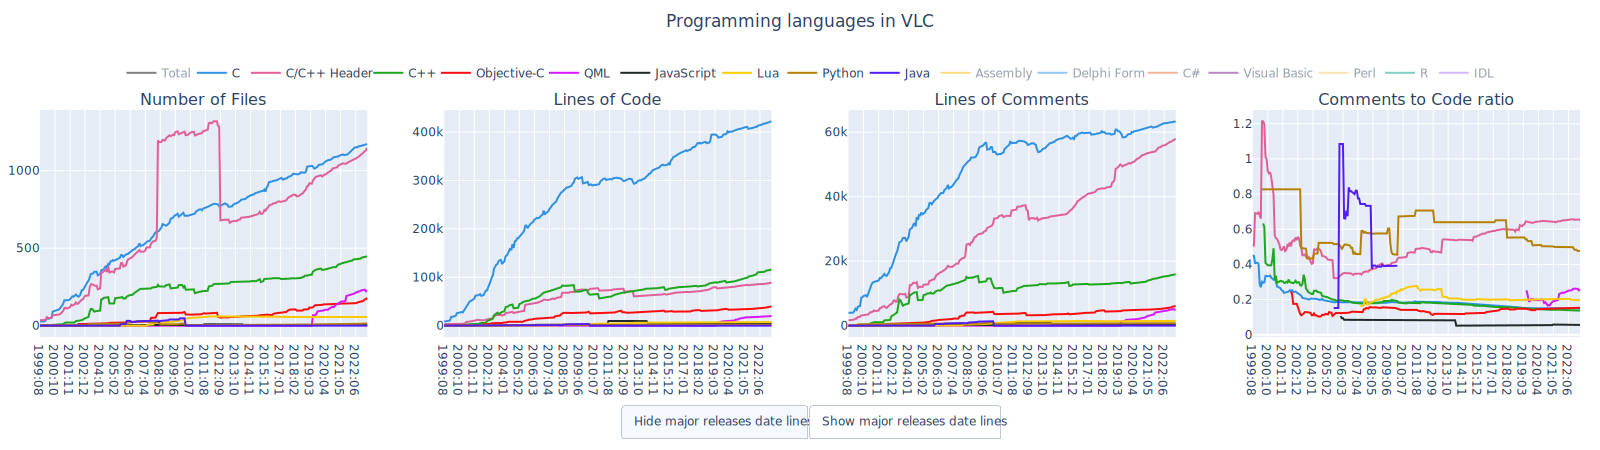

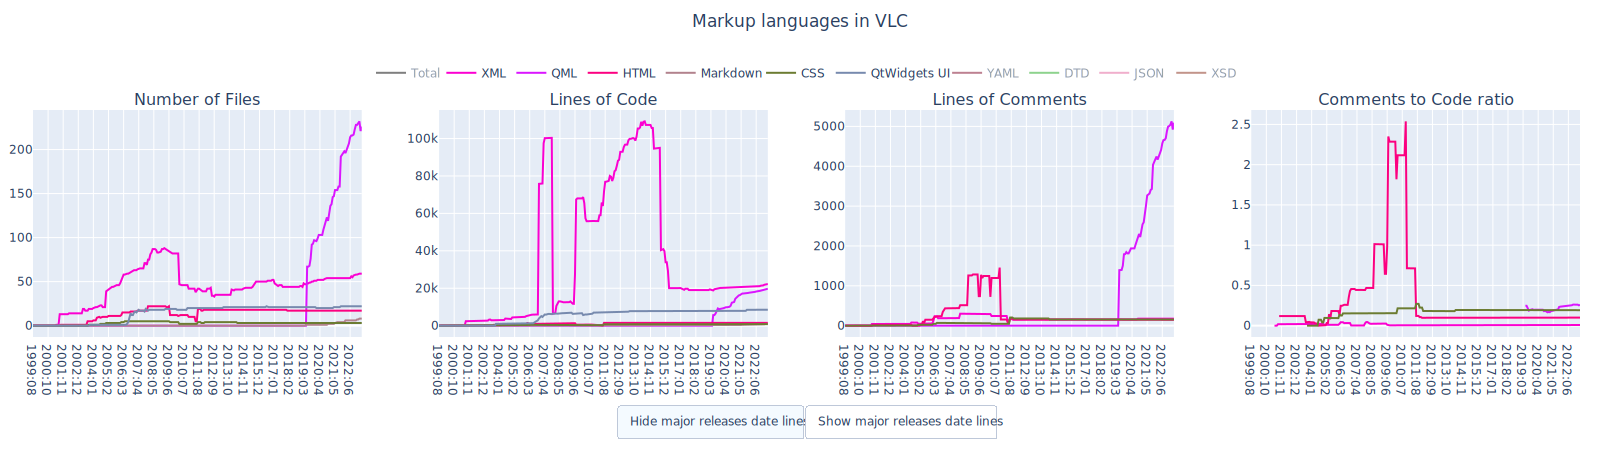

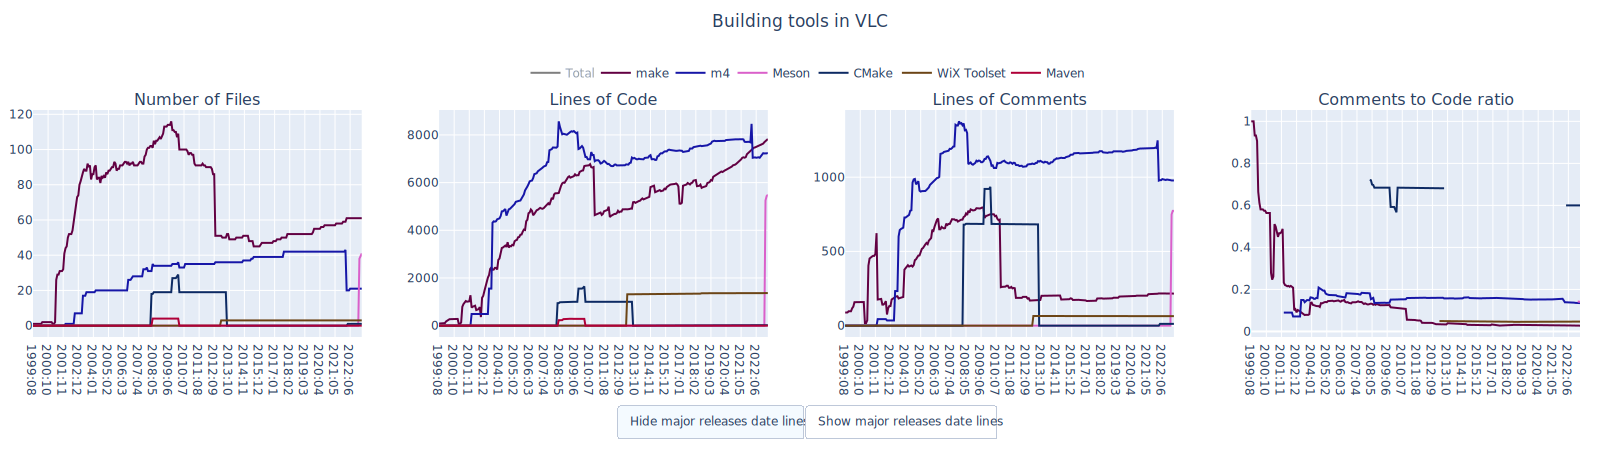

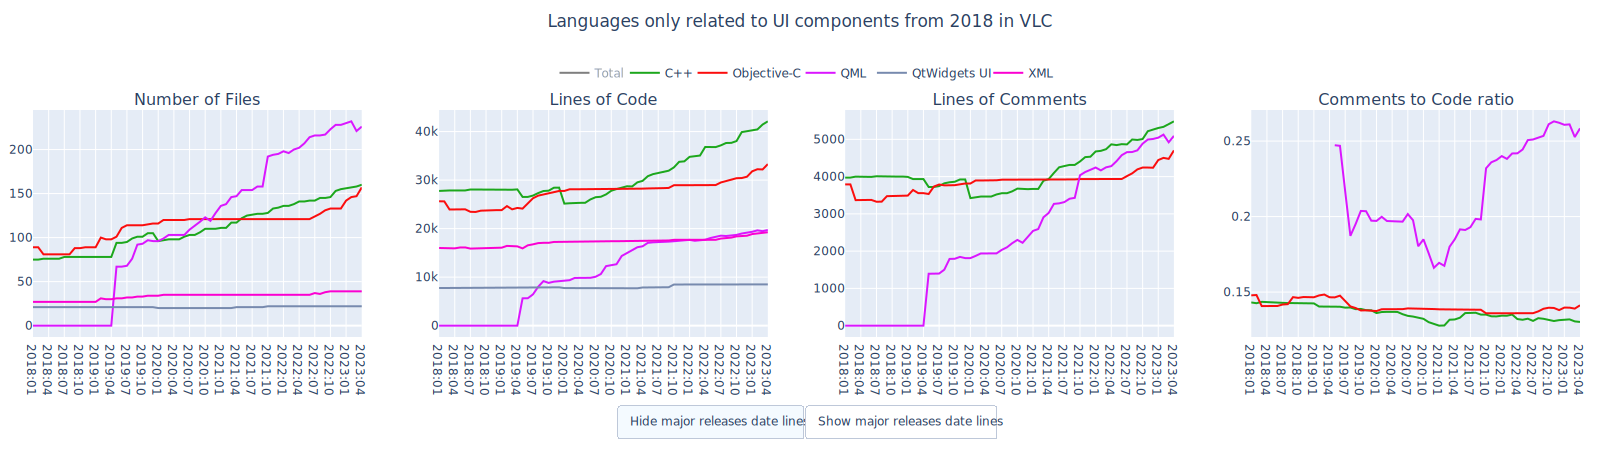

In [268]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
import plotly.io as pio

def plot_languages(data, languages, title, fileName):
    keys = ["files", "code", "comment", "ratio"]
    subplot_titles = ["Number of Files", "Lines of Code", "Lines of Comments", "Comments to Code ratio"]
    fig = make_subplots(rows=1, cols=len(keys), subplot_titles=subplot_titles)
    colors = [language_colors[language] for language in languages]

    # Keep a global sum of the data for each key
    sum = [[], [], [], []]
    
    for j in range(len(keys)):
        key = keys[j]       
        
        for i, language in enumerate(languages):
            # Get the value of the key for each month
            num = [data[monthYear].get(language, {key: 0 if key!="ratio" else None})[key] for monthYear in data.keys()]
            
            # Add the value to the global sum
            if key != "ratio":
                sum[j] = num if len(sum[j]) == 0 else np.add(sum[j], [0 if x is None else x for x in num])
            else:
                # In case of ratio, if a language has always no comments, exlude the code from the sum for more correct comment to code ratio
                backupKey = "comment"
                comments_num = [data[monthYear].get(language, {backupKey: 0})[backupKey] for monthYear in data.keys()]
                if all(x == 0 for x in comments_num):
                    backupKey = "code"
                    code_num = [data[monthYear].get(language, {backupKey: 0})[backupKey] for monthYear in data.keys()]
                    sum[1] = np.subtract(sum[1], code_num)

            # Don't add trace if all values are 0 (makes 'comments' plots better, since some files are autogenerated and have no comments)
            if all(x == 0 or x == None for x in num):
                continue

            # Add trace to the plot
            fig.add_trace(go.Scatter(x=list(data.keys()), y=num, mode='lines', name=language, legendgroup=language, 
                                     showlegend=j==0, line=dict(color=colors[i % len(colors)])), row=1, col=j+1)
            # In case language has very few lines of code, make the trace visible only in the legend
            if language in ['C#', 'Visual Basic', 'Perl', 'R', 'YAML', 'XSD', 'IDL', 'Delphi Form', 'JSON', 'DTD', 'Assembly']:
                fig.data[-1].visible = "legendonly"
            
        # Add a total number trace for every plot
        if languages!=["SUM"]: # Don't add total if plot is only for cloc's SUM
            if key=="ratio": # Ratio needs to be calculated separately
                sum[j] = [0 if sum[1][i] == 0 else sum[2][i]/sum[1][i] for i in range(len(sum[1]))]

            fig.add_trace(go.Scatter(x=list(data.keys()), y=sum[j], mode='lines', name="Total", legendgroup="Total", legendrank=1,
                                    showlegend=j==0, line=dict(color="#000000")), row=1, col=j+1)
            fig.data[-1].visible = "legendonly" # Hide the total trace by default

    # Add vertical lines for VLC major releases
    vlc0 = [dict(type="line", xref="x"+str(j+1), yref='paper', x0='2001:02', x1='2001:02', y0=0, y1=1,
                      line=dict(color="DarkOrange")) for j in range(len(keys))]
    vlc1 = [dict(type="line", xref="x"+str(j+1), yref='paper', x0='2009:07', x1='2009:07', y0=0, y1=1,
                      line=dict(color="DarkOrange")) for j in range(len(keys))]
    vlc2 = [dict(type="line", xref="x"+str(j+1), yref='paper', x0='2012:02', x1='2012:02', y0=0, y1=1,
                      line=dict(color="DarkOrange")) for j in range(len(keys))]
    vlc3 = [dict(type="line", xref="x"+str(j+1), yref='paper', x0='2018:02', x1='2018:02', y0=0, y1=1,
                      line=dict(color="DarkOrange")) for j in range(len(keys))]
   
    # Add buttons to show/hide major release date lines
    fig.update_layout(updatemenus=[dict(buttons=list([dict(args=["shapes", []], label="Hide major releases date lines", method="relayout"), 
        dict(args=["shapes", vlc0 + vlc1 + vlc2 + vlc3 if '2017:12' in data.keys() else vlc3], label="Show major releases date lines", method="relayout")]),
        type="buttons", direction="right", showactive=True, x=0.5, xanchor="center", y=-0.3, yanchor="top")])

    # Update title, legend and margins
    fig.update_layout(title=dict(text = title + " in VLC", xanchor = "center", yanchor="bottom", x=0.5, y = 0.94), 
                      legend=dict(orientation="h", xanchor="center", yanchor="bottom", x=0.5, y=1.1),
                      margin=dict(l=20, r=20, t=110, b=110))
    
    # I removed this to make the plot more readable
    #xaxis_title="Date", yaxis_title="Number of files", xaxis2_title="Date", yaxis2_title="Lines of code",
    #xaxis3_title="Date", yaxis3_title="Lines of comments", xaxis4_title="Date", yaxis4_title="Comments to code ratio")
    
    # Save plots as html
    #pio.write_html(fig, file='plots/vlc_'+fileName+'.html')

    # Show plots as svg (to be visible on github)
    #fig.update_layout(autosize=False, width=1600, height=450) 
    #fig.show("svg")

    fig.show()  

# Define color for every language
language_colors = {'C': '#2E91E5', 'C/C++ Header': '#E15F99', 'C++': '#1CA71C', 'Objective-C': '#FB0D0D', 'QML': '#DA16FF', 'JavaScript': '#222A2A', 'Python': '#B68100', 
                   'Visual Basic': '#750D86', 'C#': '#EB663B', 'Java': '#511CFB','R': '#00A08B', 'Perl': '#F2CB61', 'Assembly': '#F9BA00', 'IDL': '#A777F1', 'Lua': '#FBCA03', 'Delphi Form': '#2E91E5',
                   'YAML': '#7B0323', 'XML': '#FB00D1', 'HTML': '#FC0080', 'Markdown': '#B2828D', 'CSS': '#6C7C32', 'QtWidgets UI': '#778AAE', 'XSD': '#862A16', 'JSON': '#E15F99', 'DTD': '#1CA71C',
                   'make': '#620042', 'm4': '#1616A7', 'Meson': '#DA60CA', 'WiX Toolset': '#6C4516', 'CMake': '#0D2A63', 'Maven': '#AF0038', 'SUM': '#000000'}

# give me three more colors that fit the colors above in #RRGGBB format
colors = ["#FFA500", "#FF00FF", "#00FFFF", "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#800080", "#008080", "#800000", "#008000", "#000080", "#808000", "#800080", "#008080", "#808080", "#C0C0C0", "#808080", "#000000"]

# Create a list of languages for each category
programming_languages = ['C', 'C/C++ Header', 'C++', 'Objective-C', 'QML', 'JavaScript', 'Lua', 'Python', 'Java', 'Assembly', 'Delphi Form', 'C#', 'Visual Basic', 'Perl', 'R', 'IDL']
markup_languages = ['XML', 'QML', 'HTML', 'Markdown', 'CSS', 'QtWidgets UI', 'YAML', 'DTD', 'JSON', 'XSD']
build_tools = ['make', 'm4', 'Meson', 'CMake', 'WiX Toolset', 'Maven']
languages_of_gui_folder = ['C++', 'Objective-C', 'QML', 'QtWidgets UI', 'XML']

# Create plots of interest
plot_languages(all_stats, ['SUM'], "All files", "all_files")
plot_languages(all_stats, programming_languages, "Programming languages", "programming_languages")
plot_languages(all_stats, markup_languages, "Markup languages", "markup_languages")
plot_languages(all_stats, build_tools, "Building tools", "build_tools")
plot_languages(ui_stats, languages_of_gui_folder, "Languages only related to UI components from 2018", "ui_languages")